# Amazon Product Review Sentiment Analysis - EDA

## Objectives

The purpose of this notebook is to perform exploratory data analysis (EDA) on the cleaned 'Reviews' dataset, in order to understand variable distributions and gain initial insights into the data to inform downstream analyses.

Here, we will do the following:
- Learn the distribution of product ratings and sentiments (histograms)
- Visualise language used in different sentiment categories (wordclouds and barplots of most frequent words)
- Visualise sentiment trends by product and/or time (line graphs)


## Load data and libraries

In [44]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')
from wordcloud import WordCloud, STOPWORDS
import re
from collections import Counter


In [45]:
#load dataset
df = pd.read_csv('../data/Reviews_Sample_Cleaned.csv')

In [46]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Date,Sentiment
0,406806,B000LKXCB8,ALFO2XQISZ9QM,A.K.,1,1,1,1342396800,.,"What a waste!!! Hardly any ""Mirch"" (Green Chil...",2012-07-16,Negative
1,75918,B001CPOR2E,A7G9M0IE7LABX,Kevin,2,3,1,1310947200,Treat caused ulcers in my dog's GI tract,I should have known when I touched these strip...,2011-07-18,Negative
2,400895,B0016PC4TS,A22M0C1YXBGW1Y,"LuLu, Calif",8,10,1,1274486400,Waste of Money,Don't waste your money! Did nothing to repell ...,2010-05-22,Negative
3,480705,B00719WZNS,A2PA1INHPVXLBF,THE DUDE,0,0,1,1350086400,"ALL FIZZ, NOT MUCH FLAVOR",I RECIEVED MY DRINKS AND WAS LOOKING FOR LOTS ...,2012-10-13,Negative
4,103600,B005MSH01C,A3CZ8V0M91JEKP,unsatisfied user,4,5,1,1307404800,Grossest cola ever,"I've had the SodaStream SodaMix - Cola before,...",2011-06-07,Negative


## Data distributions

Plot the distributions of product ratings (1-5), sentiment category (positive/neutral/negative) and review length.

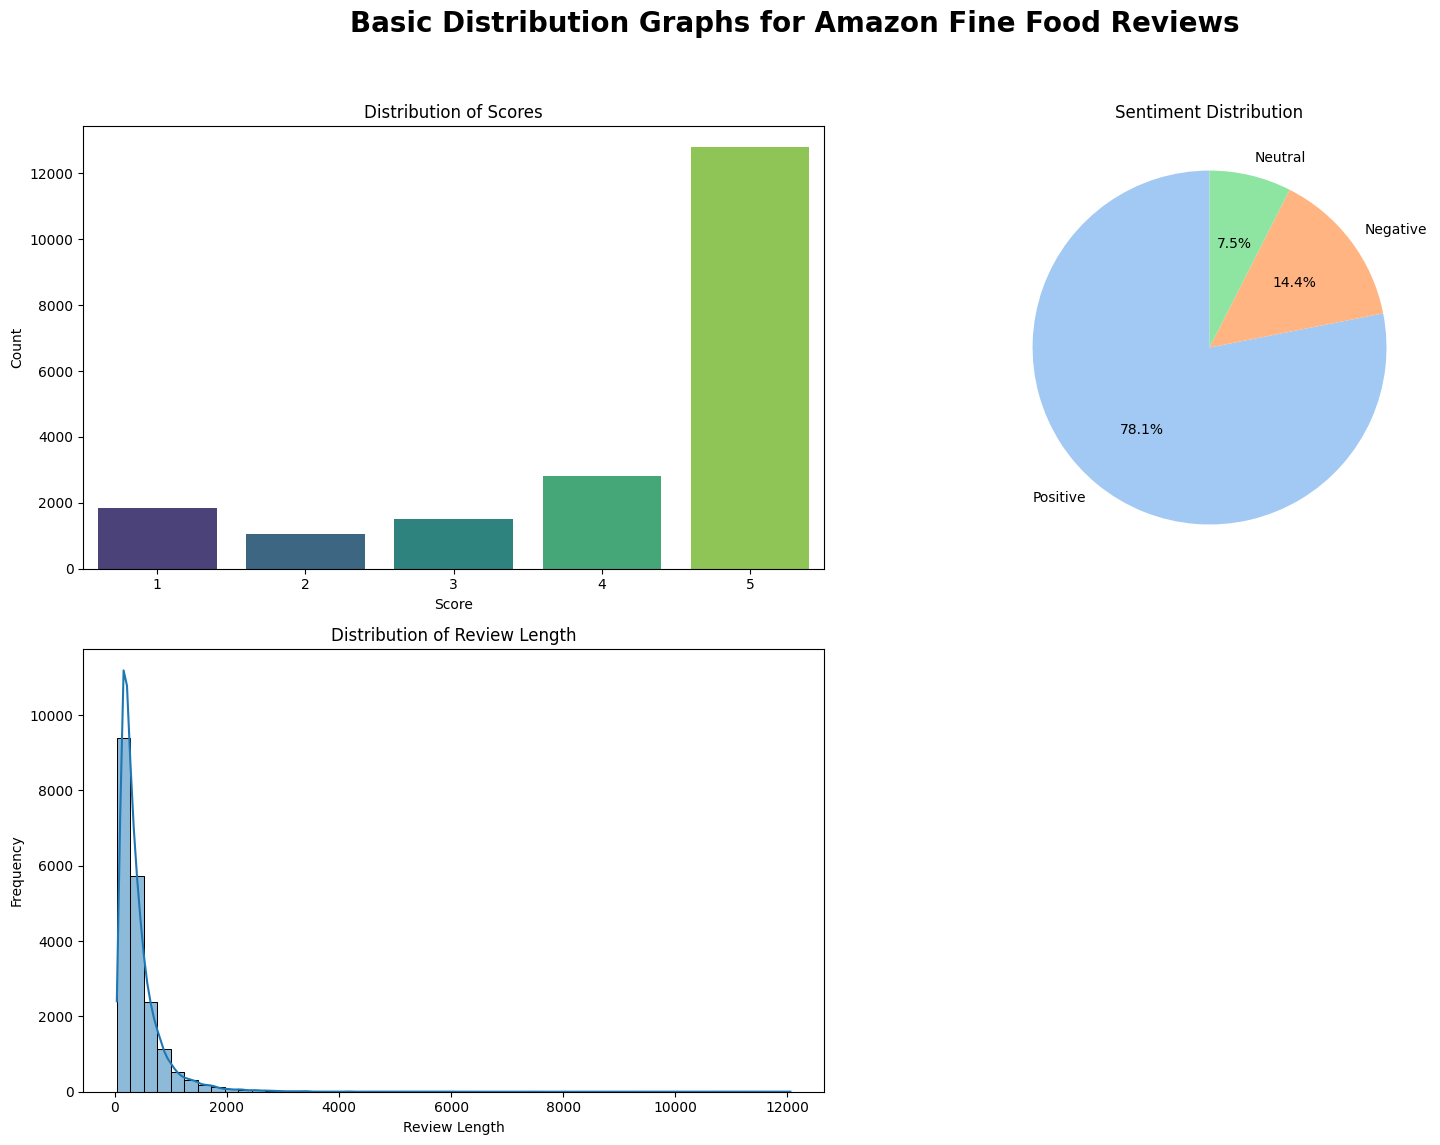

In [47]:
# Create one figure with a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Basic Distribution Graphs for Amazon Fine Food Reviews', fontsize=20, fontweight='bold')

# 1. Distribution of Scores
sns.countplot(ax=axes[0, 0], data=df, x='Score', palette='viridis')
axes[0, 0].set_title('Distribution of Scores')
axes[0, 0].set_xlabel('Score')
axes[0, 0].set_ylabel('Count')

# 2. Sentiment Distribution
sentiment_counts = df['Sentiment'].value_counts()
axes[0, 1].pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
axes[0, 1].set_title('Sentiment Distribution')
axes[0, 1].set_ylabel('')

# 3. Distribution of Review Length
df['Review Length'] = df['Text'].astype(str).str.len()
sns.histplot(ax=axes[1, 0], data=df, x='Review Length', bins=50, kde=True)
axes[1, 0].set_title('Distribution of Review Length')
axes[1, 0].set_xlabel('Review Length')
axes[1, 0].set_ylabel('Frequency')

# Remove the empty subplot
axes[1, 1].remove()

# Adjust layout and display the plots
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Helpfulness vs Score 

A box plot created using seaborn to show the distribution of the 'Helpfulness Numerator' for each score. 

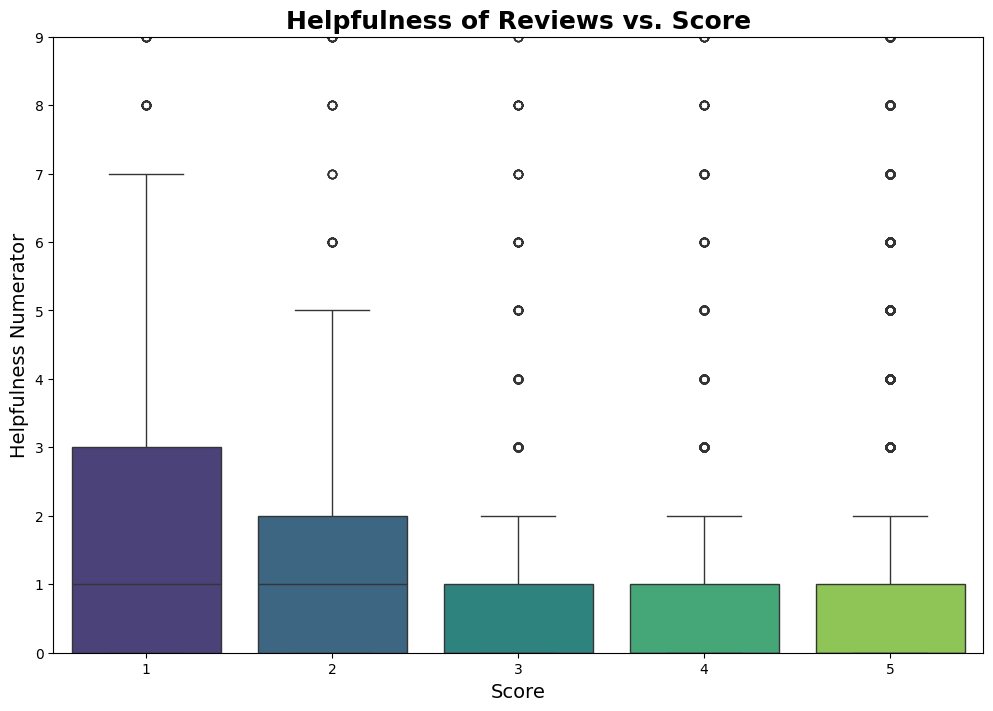

In [48]:

plt.figure(figsize=(12, 8))
sns.boxplot(x='Score', y='HelpfulnessNumerator', data=df, palette='viridis')

plt.title('Helpfulness of Reviews vs. Score', fontsize=18, fontweight='bold')
plt.xlabel('Score', fontsize=14)
plt.ylabel('Helpfulness Numerator', fontsize=14)

# Limit the y-axis for better visualisation due to extreme outliers
# Limits it to the 98th percentile of the HelpfulnessNumerator
plt.ylim(0, df['HelpfulnessNumerator'].quantile(0.97))

plt.show()


## Sentiment vs Rating

A Plotly grouped bar chart shows how sentiment (positive/negative) aligns with each score (1 to 5), giving a visual sense of how well the rating and the review sentiment agree.

In [52]:
# Count reviews by score and sentiment
sentiment_score_counts = df.groupby(['Score', 'Sentiment']).size().reset_index(name='Count')

# Build Plotly grouped bar chart
fig = px.bar(
    sentiment_score_counts,
    x='Score',
    y='Count',
    color='Sentiment',
    barmode='group',
    category_orders={'Score': sorted(df['Score'].unique())},
    title='Sentiment vs Rating Distribution',
    labels={'Count': 'Number of Reviews', 'Score': 'Rating Score'}
)

fig.update_layout(
    xaxis=dict(dtick=1),
    legend_title='Sentiment',
    bargap=0.15
)

fig.show(renderer="browser")

## Sentiment Analysis

Visualise words associated with each sentiment category using wordclouds and barplots of most frequent words

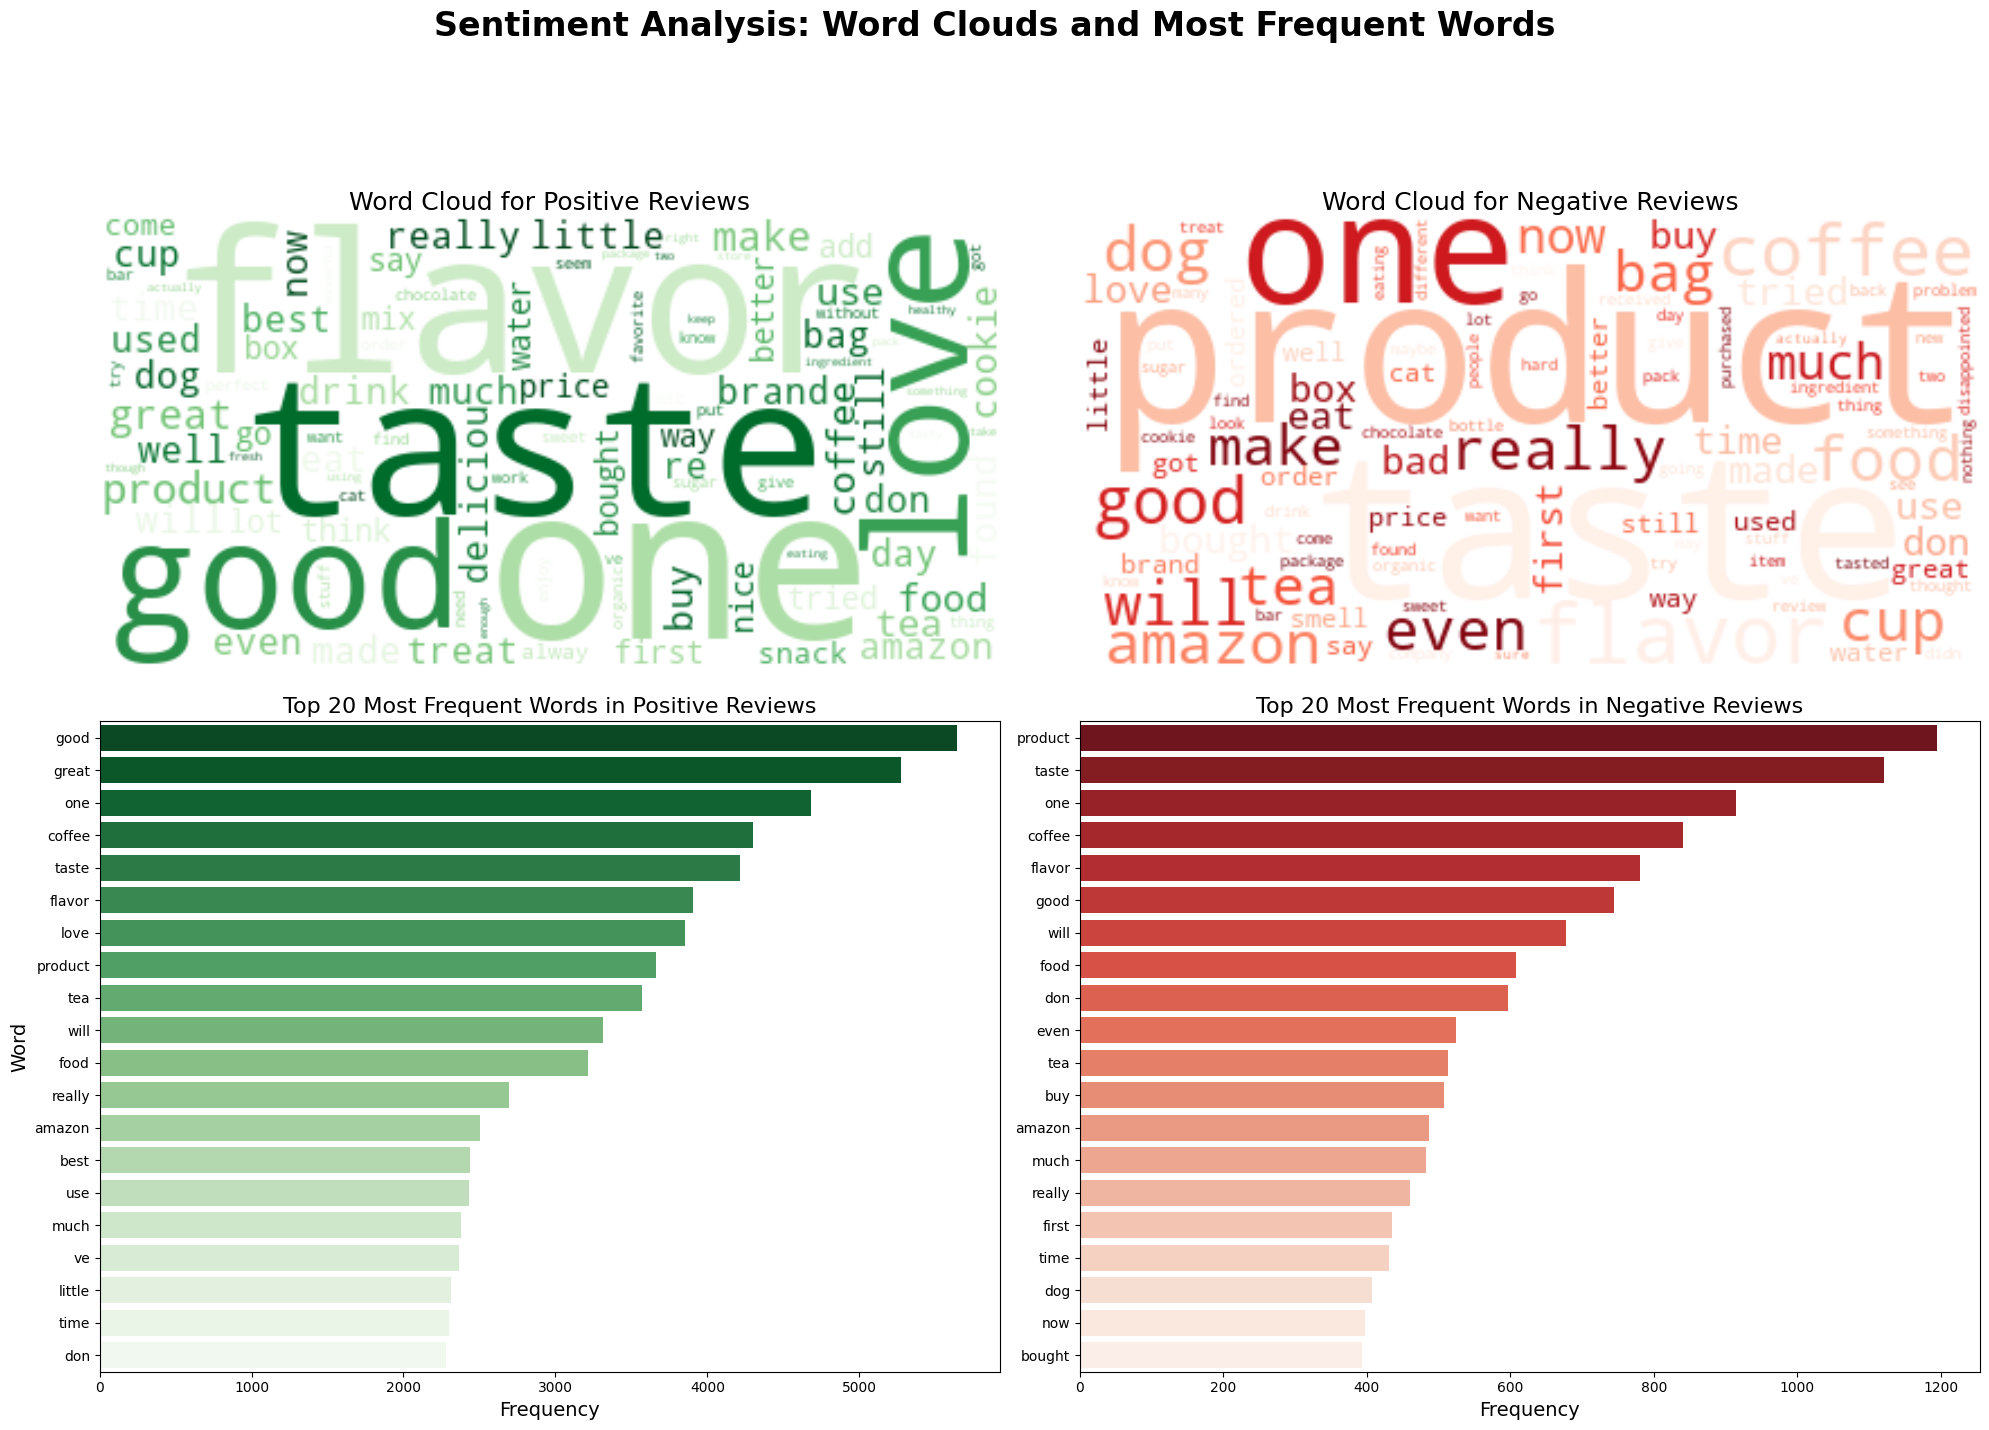

In [50]:
# 1. Text Preprocessing
# Combine all stopwords
stopwords = set(STOPWORDS)

def preprocess_text(text):
    # Ensure text is a string
    if not isinstance(text, str):
        return ""
    # Remove non-alphabetic characters and convert to lowercase
    text = re.sub('[^a-zA-Z]', ' ', text).lower()
    # Tokenise and remove stopwords
    words = text.split()
    words = [word for word in words if word not in stopwords and len(word) > 1]
    return " ".join(words)

# Apply preprocessing to the 'Text' column
df['Processed_Text'] = df['Text'].apply(preprocess_text)

# 2. Visualisation
# Separate data by sentiment
positive_reviews = df[df['Sentiment'] == 'Positive']
negative_reviews = df[df['Sentiment'] == 'Negative']

# Create one figure with a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 15))
fig.suptitle('Sentiment Analysis: Word Clouds and Most Frequent Words', fontsize=24, fontweight='bold')

# 3. Word Clouds
# Positive Reviews Word Cloud
positive_text = " ".join(review for review in positive_reviews['Processed_Text'])
wordcloud_positive = WordCloud(stopwords=stopwords, background_color="white", colormap='Greens', max_words=100).generate(positive_text)
axes[0, 0].imshow(wordcloud_positive, interpolation='bilinear')
axes[0, 0].set_title('Word Cloud for Positive Reviews', fontsize=18)
axes[0, 0].axis("off")

# Negative Reviews Word Cloud
negative_text = " ".join(review for review in negative_reviews['Processed_Text'])
wordcloud_negative = WordCloud(stopwords=stopwords, background_color="white", colormap='Reds', max_words=100).generate(negative_text)
axes[0, 1].imshow(wordcloud_negative, interpolation='bilinear')
axes[0, 1].set_title('Word Cloud for Negative Reviews', fontsize=18)
axes[0, 1].axis("off")

# 4. Bar Plots of Most Frequent Words
# Get word counts for positive reviews
positive_word_counts = Counter(" ".join(positive_reviews['Processed_Text']).split()).most_common(20)
df_positive_words = pd.DataFrame(positive_word_counts, columns=['Word', 'Frequency'])

# Get word counts for negative reviews
negative_word_counts = Counter(" ".join(negative_reviews['Processed_Text']).split()).most_common(20)
df_negative_words = pd.DataFrame(negative_word_counts, columns=['Word', 'Frequency'])

# Plot for positive reviews
sns.barplot(ax=axes[1, 0], x='Frequency', y='Word', data=df_positive_words, palette='Greens_r')
axes[1, 0].set_title('Top 20 Most Frequent Words in Positive Reviews', fontsize=16)
axes[1, 0].set_xlabel('Frequency', fontsize=14)
axes[1, 0].set_ylabel('Word', fontsize=14)

# Plot for negative reviews
sns.barplot(ax=axes[1, 1], x='Frequency', y='Word', data=df_negative_words, palette='Reds_r')
axes[1, 1].set_title('Top 20 Most Frequent Words in Negative Reviews', fontsize=16)
axes[1, 1].set_xlabel('Frequency', fontsize=14)
axes[1, 1].set_ylabel('') # Hide y-axis label for the second plot

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


## Sentiment trends

Visualise sentiment trends by product/time 

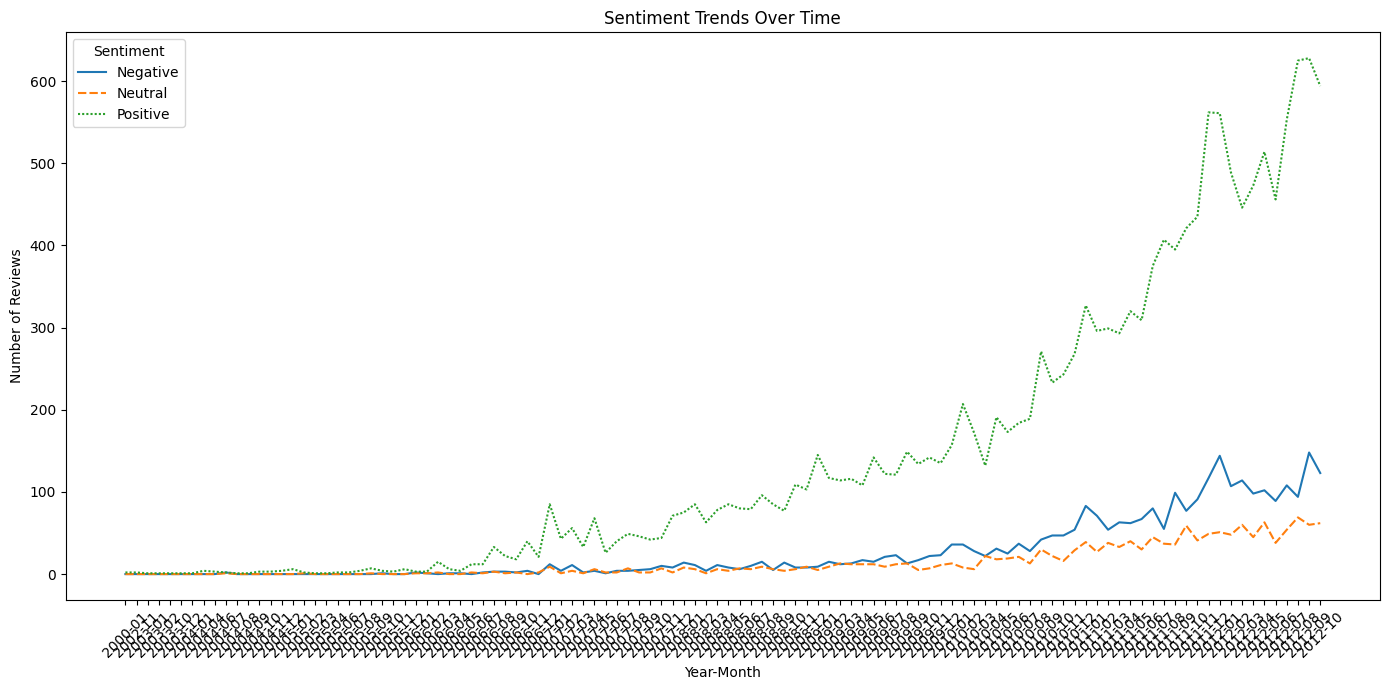

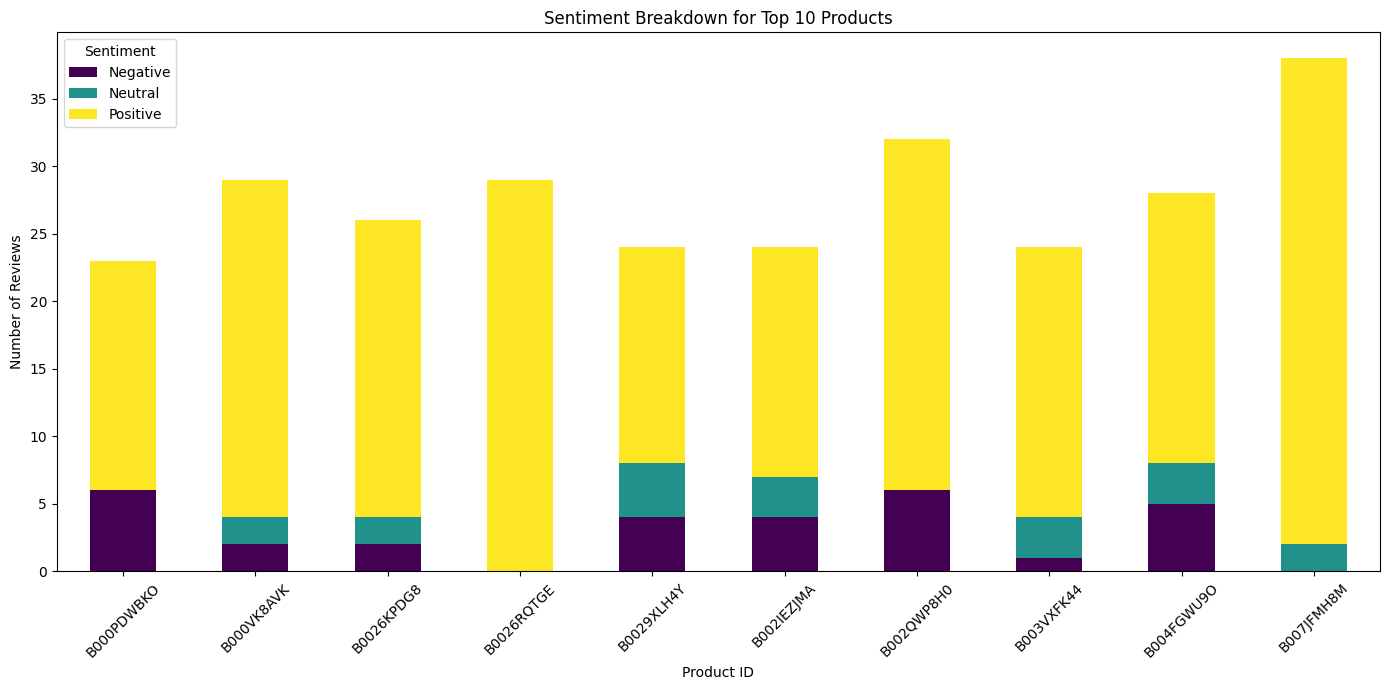

In [51]:
# Ensure date parsing
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.dropna(subset=['Date'])

# Aggregate sentiment over time (monthly)
df['YearMonth'] = df['Date'].dt.to_period('M').astype(str)
sentiment_monthly = df.groupby(['YearMonth', 'Sentiment']).size().reset_index(name='Count')
sentiment_pivot = sentiment_monthly.pivot(index='YearMonth', columns='Sentiment', values='Count').fillna(0)

# Plot sentiment trends over time
plt.figure(figsize=(14,7))
sns.lineplot(data=sentiment_pivot)
plt.xticks(rotation=45)
plt.title('Sentiment Trends Over Time')
plt.ylabel('Number of Reviews')
plt.xlabel('Year-Month')
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()

# Aggregate sentiment by product for top 10 products
top_products = df['ProductId'].value_counts().nlargest(10).index
df_top = df[df['ProductId'].isin(top_products)]
sentiment_product = df_top.groupby(['ProductId', 'Sentiment']).size().reset_index(name='Count')
product_pivot = sentiment_product.pivot(index='ProductId', columns='Sentiment', values='Count').fillna(0)

# Plot sentiment by product (stacked bar plot)
product_pivot.plot(
    kind='bar', stacked=True,
    colormap='viridis', figsize=(14,7)
)
plt.title('Sentiment Breakdown for Top 10 Products')
plt.ylabel('Number of Reviews')
plt.xlabel('Product ID')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
